# Bias and Fairness Sandbox using AScore Dataset

Objective: Evaluate Fairness of A Score model wrt to sensitive features

**ChangeLog:**
- 9 June 2023 - Completed initial assessment and reported via Model Report. Used the following sensitive features: age, marital status, gender, SEC classification
- 14 June 2023 - Defined several parity measures (NPV, PPV, FDR, FOR). Refactored code such that it can handle mixed/ multiple sfs at once
- 15 June 2023 - Created "print_report" that shows a simple assessment report


**Technical Next Steps:**

*Priority 1: Defining the Fairness Tree*
- Fairness Tree. Function that asks the user serveral questions to filter which fairness metric to use.
- Metrics Found in Fairness Tree: Define Negative Equalized Odds, Calibration Group metrics
- Define performance metrics (accuracy, recall, etc.) using Metric Frame

*Priority 2: Fairness - Accuracy Trade Off*
- EDA Tools to look at Bias and Fairness
- Trade Off Module (Looking at how fairness influence performance metrics)

*Priority 3: Rootcause Analysis*
- Identify which among the top features influence the bias

*Priority Y: Fairness Mitigation*
- Post-processing Mitigation techniques from Fairlean


*Priority Z*

- Define Brier Score and Individual fairness
- Confidence Interval

Main Reference
- Veritas Framework



In [ ]:
pip install aif360 'aif360[Reductions]'  'aif360[LawSchoolGPA]' fairlearn==0.9.0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
    true_negative_rate,
    true_positive_rate,
    demographic_parity_ratio,
    equalized_odds_ratio,
    mean_prediction,
    # _balanced_root_mean_squared_error
)

from fairlearn.metrics._base_metrics import _get_labels_for_confusion_matrix
from sklearn.metrics import confusion_matrix
from fairlearn.metrics import make_derived_metric
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

path = '/content/drive/MyDrive/data/ascore_with_protected_feats.csv'

## Data Import/ Dictionary

```python
# Identifiers
'ip_role_id', 'agent_id', 'gcashwallet',

# Training Metadata

'dataset_split'

# Label
'bad30', 'prediction', 'score'

# Timestamps
'billing_date', 'sunday_billing_date',
'due_date', 'repayment_date',

# KYC Data

'agent_id_kyc', 'gcashwallet_kyc',
'pa_town', 'pa_province', 'ca_town', 'ca_province', 'gender_id',
'gender', 'birth_date', 'nature_of_work', 'consent', 'marital_status',
'email_address_verified'

# Transaction Information

'balance_cv_balance_90',
'balance_sma_balance_90', 'balance_tot_cv_balance_180d',
'balance_tot_sma_balance_90d', 'billpay_avg_monthly_pay_cnt',
'billpay_cc_sma_amt', 'billpay_consistency', 'billpay_govt_sma_amt',
'billpay_homecredit_amt_60d', 'billpay_loans_amt_pct',
'billpay_months_active', 'billpay_pay_date_stddev',
'fs_ginsure_trans_amt_90d', 'fs_ginsure_trans_cnt_std',
'fs_ginvest_m_avg_bal_std', 'fs_gsave_deposit_cnt_90d',
'fs_gsave_m_avg_growth_rate', 'kyc_crp_cnt', 'kyc_crp_gcredit_pct',
'kyc_source_of_funds_bank', 'transactions_buyload_trans_med_90d',
'transactions_days_from_first_login',
'transactions_fundin_trans_date_delta_med_180d',
'transactions_fundout_failed_trans_cnt_60d',
'transactions_fundout_trans_amt_avg_60d',
'transactions_fundout_trans_date_delta_med_180d',
'transactions_offline_cashin_avg_use_case_amt_pct',
'transactions_offline_cashin_trans_med_90d',
'transactions_online_cashin_avg_inflow_amt_pct',
'transactions_online_spending_avg_outflow_amt_pct',
'transactions_online_spending_sma_use_case_amt', 'transactions_recency',
'transactions_scan2pay_convenience_med_amt_180d',
'transactions_scan2pay_trans_med_90d',
'transactions_sendmoney_avg_use_case_amt_pct',
'transactions_sendmoney_rcv_avg_inflow_amt_pct',
'transactions_utilities_avg_outflow_amt_pct',
'transactions_utilities_cv_use_case_amt',
'transactions_webpay_ecommerce_med_amt_180d',
'transactions_webpay_trans_med_90d',
```


In [ ]:
df = pd.read_csv(path)
print('Size of thee DataFrame', df.shape)
print('DataFrame Columns:', df.columns)
df

Size of thee DataFrame (463793, 64)
DataFrame Columns: Index(['ip_role_id', 'agent_id', 'gcashwallet', 'dataset_split', 'bad30',
       'prediction', 'score', 'billing_date', 'sunday_billing_date',
       'due_date', 'repayment_date', 'balance_cv_balance_90',
       'balance_sma_balance_90', 'balance_tot_cv_balance_180d',
       'balance_tot_sma_balance_90d', 'billpay_avg_monthly_pay_cnt',
       'billpay_cc_sma_amt', 'billpay_consistency', 'billpay_govt_sma_amt',
       'billpay_homecredit_amt_60d', 'billpay_loans_amt_pct',
       'billpay_months_active', 'billpay_pay_date_stddev',
       'fs_ginsure_trans_amt_90d', 'fs_ginsure_trans_cnt_std',
       'fs_ginvest_m_avg_bal_std', 'fs_gsave_deposit_cnt_90d',
       'fs_gsave_m_avg_growth_rate', 'kyc_crp_cnt', 'kyc_crp_gcredit_pct',
       'kyc_source_of_funds_bank', 'transactions_buyload_trans_med_90d',
       'transactions_days_from_first_login',
       'transactions_fundin_trans_date_delta_med_180d',
       'transactions_fundout_failed

,ip_role_id,agent_id,gcashwallet,dataset_split,bad30,prediction,score,billing_date,sunday_billing_date,due_date,...,pa_province,ca_town,ca_province,gender_id,gender,birth_date,nature_of_work,consent,marital_status,email_address_verified
0,217010000020139921503,100029892,9276859252,train,0,0.563409,432,20210727,20210718,2021-08-11 00:00:00,...,NaN,BULI / CUPANG,NCR,2.0,FEMALE,1993-07-21,Manufacturing and Production,0.0,Single,1.0
1,217010000017512486690,100094848,9157039015,train,0,0.189596,555,20210101,20201220,2021-01-16 00:00:00,...,NaN,Tandang Sora,METRO MANILA,1.0,MALE,1978-06-26,Unemployed,0.0,Single,1.0
2,217010000010782419647,100213032,9666953206,val,0,0.739763,375,20210715,20210704,2021-07-30 00:00:00,...,NaN,MARIKINA HEIGHTS,MARIKINA NCR,0.0,NaN,1972-04-12,GOVERNMENT EMPLOYEE,0.0,NaN,1.0
3,217010000022471413540,100228945,9270470148,train,0,0.805375,348,20210116,20210103,2021-01-31 00:00:00,...,NaN,SAN PASCUAL,BATANGAS,0.0,NaN,1989-09-13,OTHERS,0.0,NaN,1.0
4,217010000004160576354,100253494,9053155094,train,0,0.843810,328,20210318,20210307,2021-04-02 00:00:00,...,NaN,Bulihan,BULACAN,2.0,FEMALE,1999-03-18,Student,0.0,Single,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463788,217010000000762835723,99849151,9121879731,test,0,0.704675,387,20210626,20210613,2021-07-11 00:00:00,...,NaN,San Jose,RIZAL,2.0,FEMALE,1987-12-17,"Manpower Services ( Contractuals, Agency, Hous...",0.0,Single,1.0
463789,217010000009697528533,99860462,9179156357,train,0,0.370284,488,20210602,20210523,2021-06-17 00:00:00,...,NaN,Barangay 521,METRO MANILA,2.0,FEMALE,1994-09-11,Healthcare and Medical Services,0.0,Single,1.0
463790,217010000005443611984,99872204,9273279221,train,0,0.414541,475,20210126,20210117,2021-02-10 00:00:00,...,NaN,Pasong Camachile I,CAVITE,2.0,FEMALE,1990-10-13,Wholesale and Retail,0.0,Married,1.0
463791,217010000032772184281,99885851,9177070712,train,0,0.140356,581,20210128,20210117,2021-02-12 00:00:00,...,NaN,CEBU,LILOAN CEBU,0.0,NaN,1990-12-02,FOOD AND RETAIL,0.0,NaN,1.0


In [ ]:
df.consent.value_counts()

0.0    457917
1.0      5245
Name: consent, dtype: int64

## Data Cleaning


### Null Investigation

Notes/ Findings:
- 630 rows from AScore Table failed to match with KYC Table. **ACTION**: Drop Rows
- Gender column contains ['FEMALE', 'MALE', '0']. Replaced '0 (Count: 16,356) with np.nan. 287,442 rows (61.98%) do not have gender information
- 302177 rows (65%) do not have marital status information


#### Gender Cleanup

In [ ]:
# Cleaning Gender Columns
rows = df.shape[0]
df.gender = df.gender.replace('0', np.nan)
df.gender_id = df.gender_id.fillna(0.0)

In [ ]:
(df.loc[:, ['gender_id', 'gender', 'gcashwallet']]
   .groupby(['gender_id','gender'])
   .agg(Count=('gcashwallet', 'count'))
   .assign(Count_percent=lambda x: 100*x.Count/ x.Count.sum()))

,,Count,Count_percent
gender_id,gender,,
1.0,MALE,59545,33.765048
2.0,FEMALE,116806,66.234952


#### Marital Status Cleanup
- Merge "Single", "SINGLE", "S", "SINGE", "UM" (Unmarried),
- Merge "Married", "MARIED", "M"
- Retain and Merge "Separated", "SEPARATED"
- Retain and Merge "Widowed" and "WIDOWED"
- Others will be converted to null
- Create a new column containing "Never married" and "Married". Married combines Separated, Married, Widowed


In [ ]:
df.marital_status.value_counts()

Single            86439
Married           54062
MARITAL STATUS     9152
SINGLE             5267
MARRIED            2161
Separated          1900
Widowed            1445
S                   350
M                   100
SEPARATED            55
WIDOWED              35
FILIPINO              7
SINGE                 4
1986-08-29            1
UM                    1
1996-01-30            1
1987-04-02            1
1991-10-31            1
1988-05-03            1
09164210785           1
1997-06-12            1
1990-03-03            1
Name: marital_status, dtype: int64

In [ ]:
MARITAL_STATUS_MAPPING = {
    'SINGLE': 'SINGLE',
    'SINGE': 'SINGLE',
    'S' : 'SINGLE',
    'UM': 'SINGLE',
    'SEPARATED': 'SEPARATED',
    'WIDOWED': 'WIDOWED',
    'MARRIED': 'MARRIED',
    'M' : 'MARRIED',
    }

df.marital_status = df.marital_status.str.upper().map(MARITAL_STATUS_MAPPING)
df['marital_status__never_married'] = df.marital_status.map({'SINGLE':1,
                                                             'MARRIED': 0,
                                                             'SEPARATED':0,
                                                             'WIDOWED':0})

#### Age Cleanup

- Convert birth date to date time format and compute the age as of 2023
- Bin ages as follows: '< 18', '18-24' '25-34', '35-44', '45-54', '55-64',  '65 and older'

In [ ]:
# Date format yyyy-mm-dd

df.birth_date = pd.to_datetime(df.birth_date)
df['age__2023'] = 2023 - df.birth_date.dt.year
df['age__2023__ranges'] = pd.cut(x=df.age__2023,
                                  bins=[0, 17, 24, 34, 44, 54, 64, 100],
                                  labels=['< 18', '18-24', '25-34',
                                          '35-44', '45-54',
                                          '55-64',  '65 and older'])

In [ ]:
df.age__2023__ranges.value_counts()

25-34           213778
35-44           160666
45-54            61000
55-64            14790
18-24            11839
65 and older      1088
< 18                 0
Name: age__2023__ranges, dtype: int64

### Prepare Dataset for Export to Data Robot
- Add dataset split tags
- Drop kyc nulls

In [ ]:
df['dataset_split__dr'] = df.dataset_split.map({'train': 't', 'val':'v', 'test':'h'})

In [ ]:
dff = df.dropna(subset=['agent_id_kyc', 'gcashwallet_kyc'])

In [ ]:
# dff.to_csv('/content/drive/MyDrive/data/ascore-with-sensitive-feats.csv', index=False)

In [ ]:
# dff.sample(100).to_csv('/content/drive/MyDrive/data/ascore-with-sensitive-feats-sample.csv', index=False)

## (Start) Quick Exploration of Sensitive Feature Distribution

Defining additional columns that reflect thresholds for various loan products
- GCredit Threshold: 1 if Prediction <=0.30, 0 otherwise
- GLoan Threshold: 1 if Prediction <=0.60, 0 otherwise
- Normal Threshold: 1 if Prediction <= 0.50, 0 otherwise

1 means that the user is qualified and will be offered the product i.e. the user is a good customer such that Bad30 ~= 0

Defining "good30" which is the inverse of "bad30" to align with the defined threshold results i.e. good30==1 means a good customer


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/ascore-with-sensitive-feats-and-income-class.csv')

# defining a subset of df to be used for data exploration and fairness testing
# zf = df.copy()

# zf['above_gcredit'] = (zf.prediction<=0.30).map(int)
# zf['above_gloan'] =  (zf.prediction<=0.60).map(int)
# zf['above_normal'] = (zf.prediction<=0.50).map(int)
# zf['good30'] = zf.bad30.map({0:1, 1:0})

<ipython-input-7-d2ca76b6596a>:1: DtypeWarning: Columns (74) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/data/ascore-with-sensitive-feats-and-income-class.csv')


In [ ]:
df.columns

Index(['ip_role_id', 'agent_id', 'gcashwallet', 'dataset_split', 'bad30',
       'prediction', 'score', 'billing_date', 'sunday_billing_date',
       'due_date', 'repayment_date', 'balance_cv_balance_90',
       'balance_sma_balance_90', 'balance_tot_cv_balance_180d',
       'balance_tot_sma_balance_90d', 'billpay_avg_monthly_pay_cnt',
       'billpay_cc_sma_amt', 'billpay_consistency', 'billpay_govt_sma_amt',
       'billpay_homecredit_amt_60d', 'billpay_loans_amt_pct',
       'billpay_months_active', 'billpay_pay_date_stddev',
       'fs_ginsure_trans_amt_90d', 'fs_ginsure_trans_cnt_std',
       'fs_ginvest_m_avg_bal_std', 'fs_gsave_deposit_cnt_90d',
       'fs_gsave_m_avg_growth_rate', 'kyc_crp_cnt', 'kyc_crp_gcredit_pct',
       'kyc_source_of_funds_bank', 'transactions_buyload_trans_med_90d',
       'transactions_days_from_first_login',
       'transactions_fundin_trans_date_delta_med_180d',
       'transactions_fundout_failed_trans_cnt_60d',
       'transactions_fundout_trans_amt

In [ ]:
y_true_col = 'good30'
y_pred_col = 'above_normal'
y_prob_col = 'prediction'
sensitive_feature = ['gender']

### Quick Visualizations

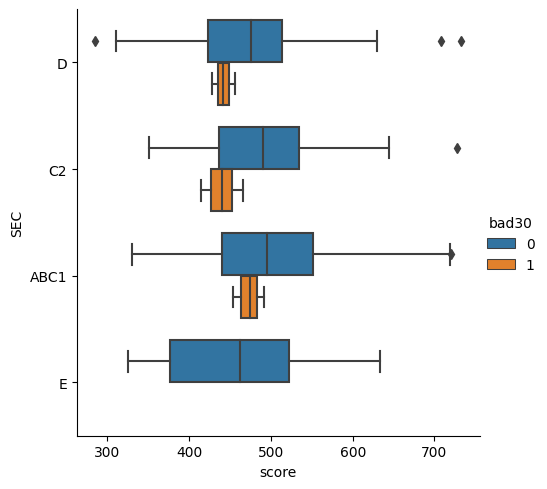

In [ ]:
sns.catplot(zf, x='score', y='SEC', hue='bad30', kind='box')

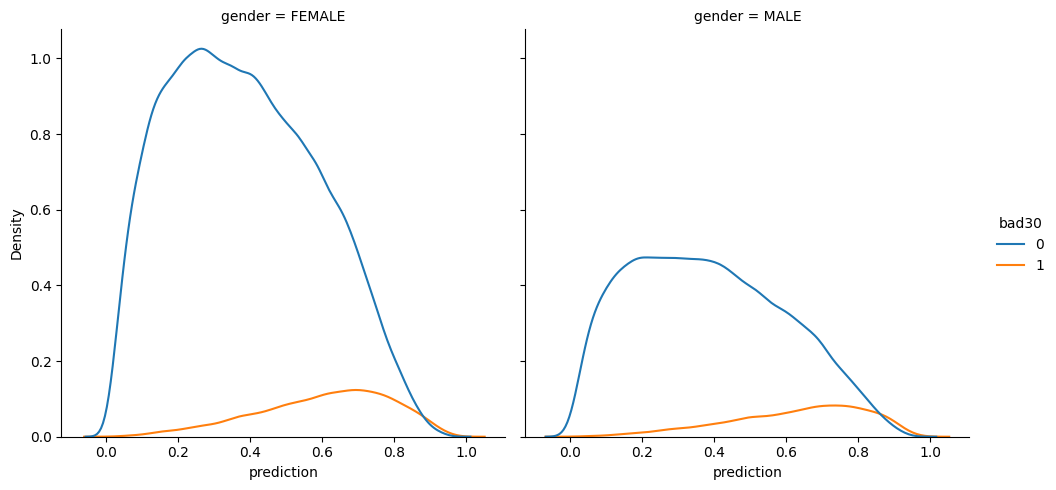

In [ ]:
sns.displot(zf, x='prediction', hue='bad30', kind='kde', col='gender')

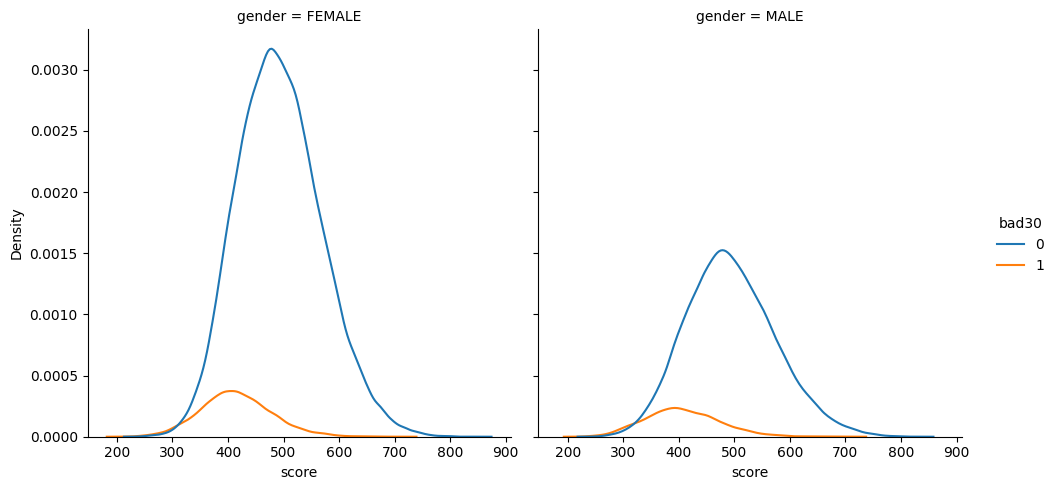

In [ ]:
sns.displot(zf, x='score', hue='bad30', col='gender', kind='kde')

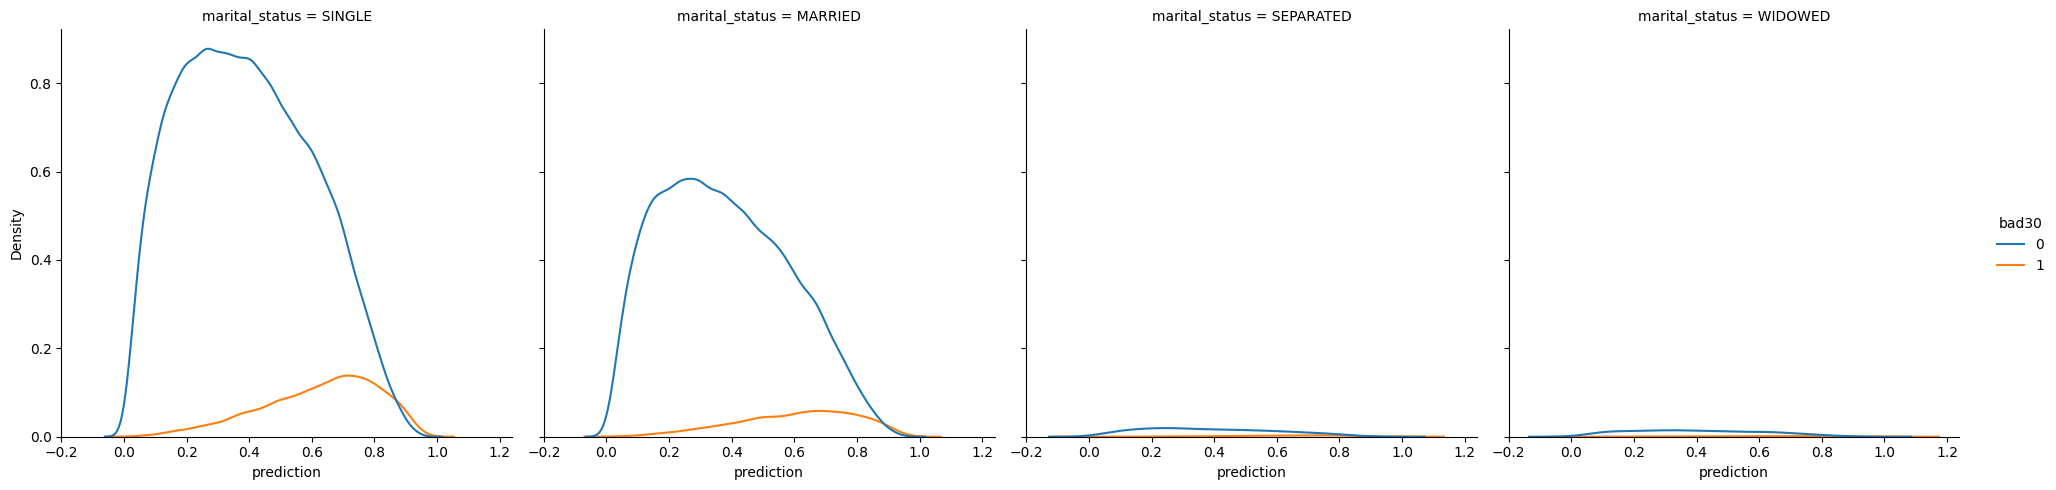

In [ ]:
sns.displot(zf, x='prediction', hue='bad30', col='marital_status', kind='kde')

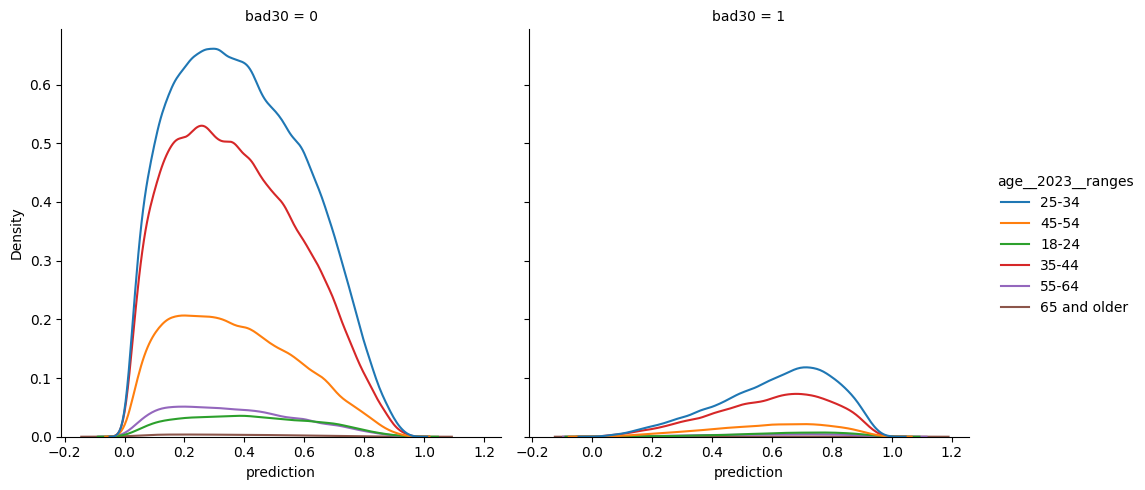

In [ ]:
sns.displot(zf, x='prediction', hue='age__2023__ranges', kind='kde', col='bad30')

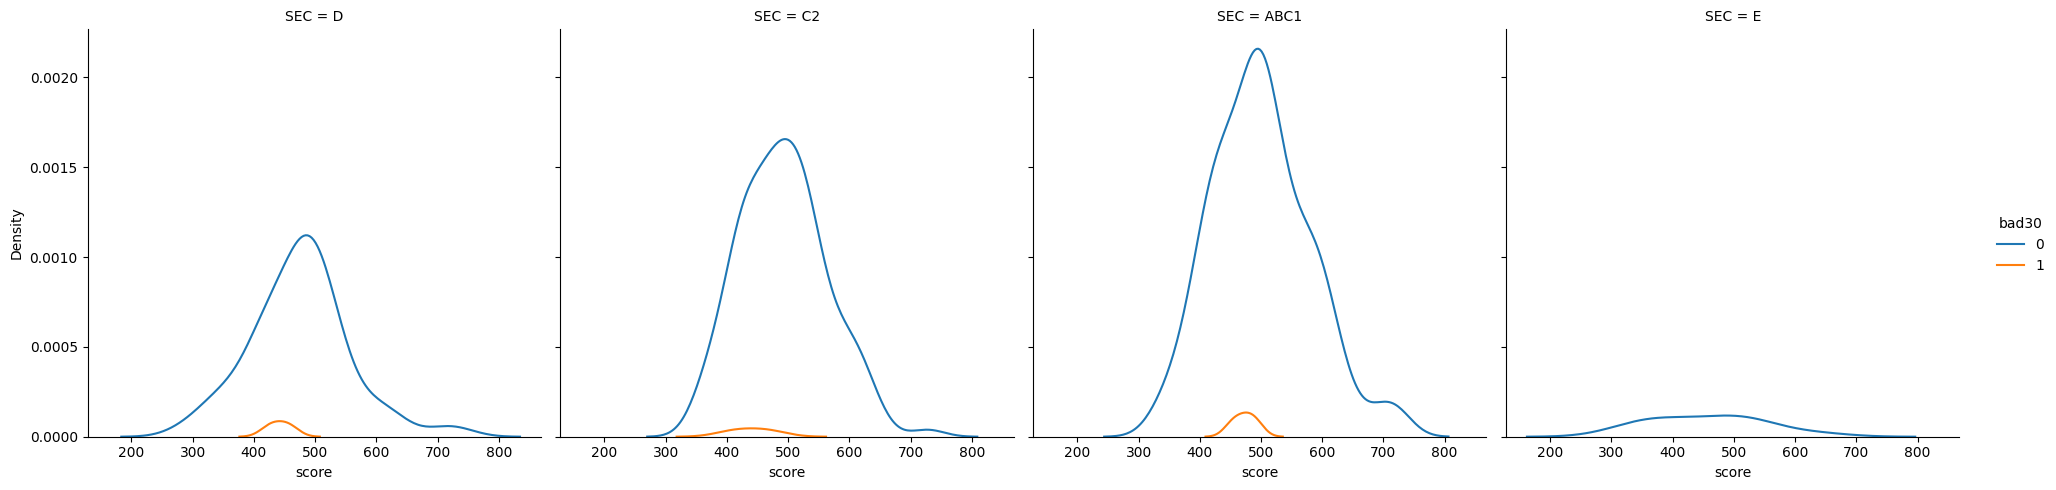

In [ ]:
sns.displot(zf, x='score', hue='bad30', kind='kde', col='SEC')

## Fairness Testing using Fairlearn

### Defining Fairness Functions

In [ ]:
## Additional Metrics

def negative_predictive_value(y_true,
                       y_pred,
                       sample_weight=None,
                       pos_label=None) -> float:

    unique_labels = _get_labels_for_confusion_matrix(np.vstack((y_true, y_pred)),
                                                     pos_label)
    npv, fdr, fo_rate, ppv = confusion_matrix(y_true,
                                                y_pred,
                                                sample_weight=sample_weight,
                                                labels=unique_labels,
                                                normalize="pred").ravel()
    return npv

def false_discovery_rate(y_true,
                       y_pred,
                       sample_weight=None,
                       pos_label=None) -> float:

    unique_labels = _get_labels_for_confusion_matrix(np.vstack((y_true, y_pred)),
                                                     pos_label)
    npv, fdr, fo_rate, ppv = confusion_matrix(y_true,
                                                y_pred,
                                                sample_weight=sample_weight,
                                                labels=unique_labels,
                                                normalize="pred").ravel()
    return fdr

def false_omission_rate(y_true,
                       y_pred,
                       sample_weight=None,
                       pos_label=None) -> float:

    unique_labels = _get_labels_for_confusion_matrix(np.vstack((y_true, y_pred)),
                                                     pos_label)
    npv, fdr, fo_rate, ppv = confusion_matrix(y_true,
                                                y_pred,
                                                sample_weight=sample_weight,
                                                labels=unique_labels,
                                                normalize="pred").ravel()
    return fo_rate

def positive_predictive_value(y_true,
                       y_pred,
                       sample_weight=None,
                       pos_label=None) -> float:

    unique_labels = _get_labels_for_confusion_matrix(np.vstack((y_true, y_pred)),
                                                     pos_label)
    npv, fdr, fo_rate, ppv = confusion_matrix(y_true,
                                                y_pred,
                                                sample_weight=sample_weight,
                                                labels=unique_labels,
                                                normalize="pred").ravel()
    return ppv

# Additional Ratios
def recall_parity_ratio(y_true, y_pred, *, sensitive_features,
                         method="between_groups", ratio=True,sample_weight=None):
    mf = MetricFrame(metrics={'tpr':true_positive_rate},
                     y_true=y_true,
                     y_pred=y_pred,
                     sensitive_features=sensitive_features)
    # eo = _get_eo_frame(y_true, y_pred, sensitive_features, sample_weight)

    return min(mf.ratio(method=method))


def equalized_odds_ratio_modified(y_true, y_pred, *, sensitive_features,
                         method="between_groups", sample_weight=None):
    mf = MetricFrame(metrics={'tpr':true_positive_rate, 'fpr': false_positive_rate},
                     y_true=y_true,
                     y_pred=y_pred,
                     sensitive_features=sensitive_features)
    # eo = _get_eo_frame(y_true, y_pred, sensitive_features, sample_weight)

    return min(mf.ratio(method=method).loc[lambda x: x>0])

def false_discovery_rate_parity_ratio(y_true, y_pred, *, sensitive_features,
                         method="between_groups", sample_weight=None):
    mf = MetricFrame(metrics={'fpr':false_discovery_rate},
                     y_true=y_true,
                     y_pred=y_pred,
                     sensitive_features=sensitive_features)

    return min(mf.ratio(method=method))

def false_omission_rate_parity_ratio(y_true, y_pred, *, sensitive_features,
                         method="between_groups", sample_weight=None):
    mf = MetricFrame(metrics={'for':false_omission_rate},
                     y_true=y_true,
                     y_pred=y_pred,
                     sensitive_features=sensitive_features)
    # eo = _get_eo_frame(y_true, y_pred, sensitive_features, sample_weight)


    return min(mf.ratio(method=method))

def precision_parity_ratio(y_true, y_pred, *, sensitive_features,
                         method="between_groups", sample_weight=None):
    mf = MetricFrame(metrics={'ppv':precision_score},
                     y_true=y_true,
                     y_pred=y_pred,
                     sensitive_features=sensitive_features)
    # eo = _get_eo_frame(y_true, y_pred, sensitive_features, sample_weight)

    return min(mf.ratio(method=method))

def true_negative_rate_parity(y_true, y_pred, *, sensitive_features,
                         method="between_groups", sample_weight=None):
    mf = MetricFrame(metrics={'tnr':true_negative_rate},
                     y_true=y_true,
                     y_pred=y_pred,
                     sensitive_features=sensitive_features)
    # eo = _get_eo_frame(y_true, y_pred, sensitive_features, sample_weight)

    return min(mf.ratio(method=method))

def negative_predictive_value_parity(y_true, y_pred, *, sensitive_features,
                         method="between_groups", sample_weight=None):
    mf = MetricFrame(metrics={'npv':negative_predictive_value},
                     y_true=y_true,
                     y_pred=y_pred,
                     sensitive_features=sensitive_features)
    # eo = _get_eo_frame(y_true, y_pred, sensitive_features, sample_weight)

    return min(mf.ratio(method=method))

def positive_predictive_value_parity(y_true, y_pred, *, sensitive_features,
                         method="between_groups", sample_weight=None):
    mf = MetricFrame(metrics={'ppv':positive_predictive_value},
                     y_true=y_true,
                     y_pred=y_pred,
                     sensitive_features=sensitive_features)
    # eo = _get_eo_frame(y_true, y_pred, sensitive_features, sample_weight)

    return min(mf.ratio(method=method))

### Utility Functions

In [ ]:
def get_data_subset(df, y_true_col, y_pred_col, y_prob_col, sf_cols=[], impute_strategy='drop'):
    if impute_strategy=='drop':
        return df[[y_true_col, y_pred_col, y_prob_col]+sf_cols].dropna(subset=sf_cols)

    else:
        return df[[y_true_col, y_pred_col, y_prob_col]+sf_cols].dropna(subset=sf_cols)



def generate_metric_frame(df, y_true_col, y_pred_col, y_prob_col, sf_cols=[],
                          aggregate=None, **mfkwargs):

    _metrics = [accuracy_score,
               precision_score,
               recall_score,
               selection_rate,
               true_negative_rate,
               false_positive_rate,
               false_negative_rate,
               true_positive_rate,
               negative_predictive_value,
               false_discovery_rate,
               false_omission_rate,
               positive_predictive_value,

               count]

    metrics = {m.__name__:m for m in _metrics}

    s_df = get_data_subset(df, y_true_col,
                           y_pred_col, y_prob_col,
                           sf_cols)

    mf = MetricFrame(
        metrics=metrics,
        y_true=s_df[y_true_col],
        y_pred=s_df[y_pred_col],
        sensitive_features=s_df[sf_cols],
        **mfkwargs)

    if not aggregate:
        return mf
    elif aggregate=='by_group':
        return mf.by_group
    elif aggregate=='ratio':
        return mf.ratio
    else:
        None




### Compute Fairness Scores

- define a group mask

In [ ]:
get_data_subset(df, y_true_col, y_pred_col, y_prob_col, sf_cols=['age__2023__ranges'], impute_strategy='drop')


,good30,above_normal,prediction,age__2023__ranges
0,1,0,0.563409,25-34
1,1,1,0.189596,45-54
2,1,0,0.739763,45-54
3,1,0,0.805375,25-34
4,1,0,0.843810,18-24
...,...,...,...,...
463158,1,0,0.704675,35-44
463159,1,1,0.370284,25-34
463160,1,1,0.414541,25-34
463161,1,1,0.140356,25-34


In [ ]:
mf = generate_metric_frame(df, y_true_col='good30', y_prob_col='prediction', y_pred_col='above_gcredit', sf_cols=['age__2023__ranges'])

mf.by_group

,accuracy_score,precision_score,recall_score,selection_rate,true_negative_rate,false_positive_rate,false_negative_rate,true_positive_rate,negative_predictive_value,false_discovery_rate,false_omission_rate,positive_predictive_value,count
age__2023__ranges,,,,,,,,,,,,,
18-24,0.419292,0.977896,0.339617,0.301884,0.948966,0.051034,0.660383,0.339617,0.177737,0.022104,0.822263,0.977896,11839.0
25-34,0.443465,0.975519,0.378235,0.341831,0.929303,0.070697,0.621765,0.378235,0.167133,0.024481,0.832867,0.975519,213778.0
35-44,0.461000,0.976994,0.407653,0.373620,0.917803,0.082197,0.592347,0.407653,0.153222,0.023006,0.846778,0.976994,160666.0
45-54,0.466869,0.980089,0.424951,0.396033,0.908953,0.091047,0.575049,0.424951,0.130340,0.019911,0.869660,0.980089,61000.0
55-64,0.466802,0.981973,0.430642,0.405071,0.904340,0.095660,0.569358,0.430642,0.116036,0.018027,0.883964,0.981973,14790.0
65 and older,0.481618,0.986696,0.443669,0.414522,0.929412,0.070588,0.556331,0.443669,0.124019,0.013304,0.875981,0.986696,1088.0


In [ ]:
mf.ratio(method='between_groups')

accuracy_score               0.870591
precision_score              0.988672
recall_score                 0.765474
selection_rate               0.728269
true_negative_rate           0.952974
false_positive_rate          0.533490
false_negative_rate          0.842437
true_positive_rate           0.765474
negative_predictive_value    0.652850
false_discovery_rate         0.543424
false_omission_rate          0.930199
positive_predictive_value    0.988672
count                        0.005089
dtype: float64

In [ ]:
# Trying to create a Generate Fairness Report Function

# User INputs
f_df = mf.ratio(method='between_groups')
fair_threshold = 0.80
fair_metric_suggestion = "True Positive Rate"

fair_is_positive_favorable = True
fair_priority = "benefit"
fair_concern = "eligible"
fair_impact = "normal"
fair_metric_type = "ratio"

## Report Generation
print('-'*20, 'Fairness Evaluation', '-'*20, '\n')
print(f'Suggested Fairness Metric: {fair_metric_suggestion}\n\tbased on, \n\t',
      f'  fair_is_positive_favorable = {fair_is_positive_favorable}\n\t',
      f'  fair_priority = {fair_priority}\n\t',
      f'  fair_concern = {fair_concern}\n\t',
      f'  fair_impact = {fair_impact}\n\t',
      f'  fair_metric_type = {fair_metric_type}\n'
      )


f_dff = (f_df.to_frame().reset_index()
     .rename(columns={0:'fairness_score', 'index':'fairness_metric'})
     .assign(fair=lambda x:
                (x['fairness_score']>=fair_threshold)
                .map({True:"Pass", False:'Fail'}))

)



print('Identified Protected Features: \n\t{sfs}\n'.format(sfs=',\n\t'.join([i.replace("__", "-").replace("_", " ").title() for i in mf.by_group.index.names])))
print(f'Fairness Treshold:\n\t{fair_threshold*100:0.2f}%\n')
print(f'Fairness Metrics:')
for i, (fm, score, feval) in f_dff.iterrows():
    print(f'\t{fm.replace("_", " ").title()}',
          ' '*(35-len(fm)-5),
          f'{score*100:0.2f}%  ({feval})')




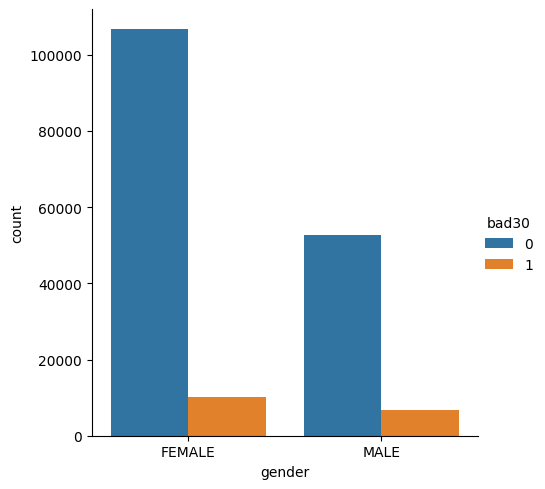

In [ ]:
sns.catplot(df.dropna(subset='gender'), x='gender', hue='bad30', kind='count')

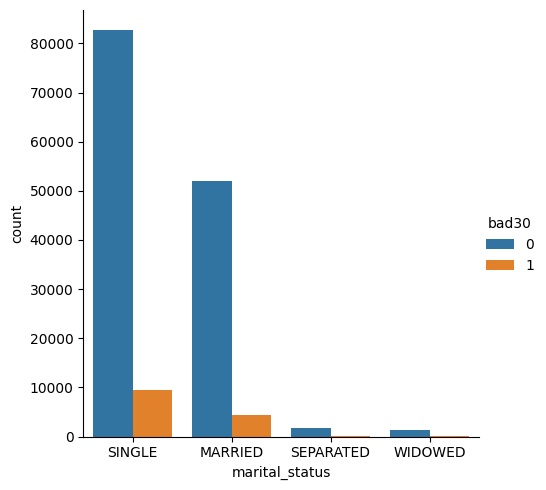

In [ ]:
sns.catplot(df.dropna(subset='marital_status'), x='marital_status', hue='bad30', kind='count')

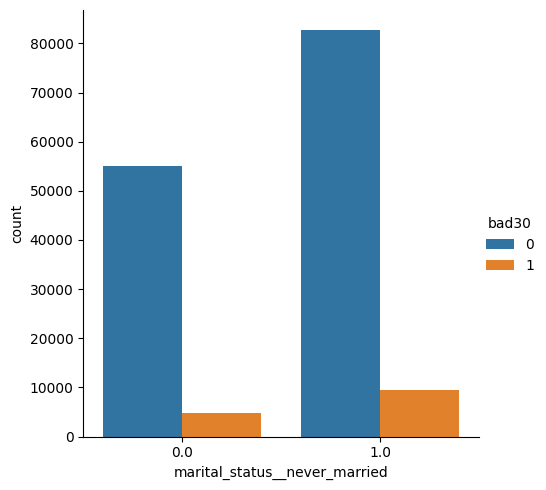

In [ ]:
sns.catplot(df.dropna(subset='marital_status__never_married'), x='marital_status__never_married', hue='bad30', kind='count')

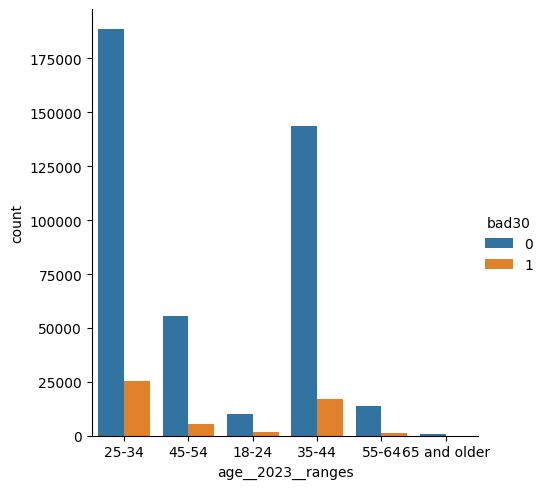

In [ ]:
sns.catplot(df.dropna(subset='age__2023__ranges'), x='age__2023__ranges', hue='bad30', kind='count')


<Axes: >

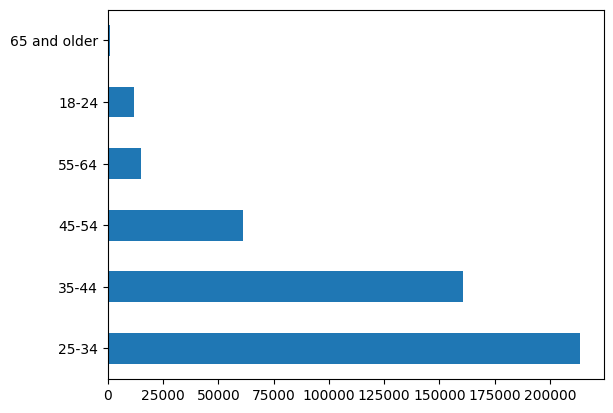

In [ ]:
df.age__2023__ranges.dropna().value_counts().plot(kind='barh')

In [ ]:
def visualize_fairness_metrics(mf, relative=True,
                               metric='selection rate', threshold=0.80):
    mf = mf.by_group
    if relative:
        mf = (mf/mf.max())
        print('Results are taken relative to the maximum value for the metric')

    mf = mf.reset_index()
    sensitive_feature = mf.columns[0]
    g = sns.catplot(mf,
                    kind='bar', x=metric, y=sensitive_feature)
    g.set(xlim=(0, 1))
    if relative:
        for ax in g.axes.flatten():
            ax.axvline(threshold, ls='-', color='black')



    return g

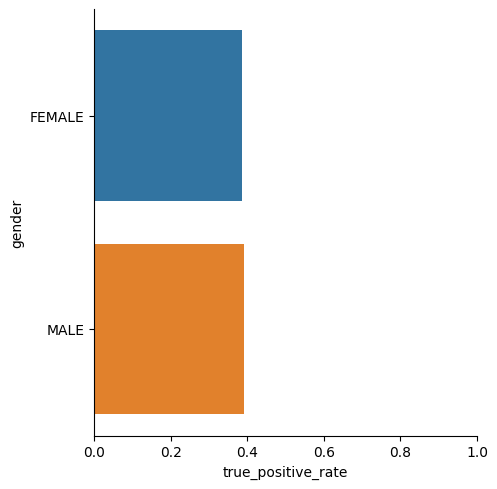

In [ ]:
visualize_fairness_metrics(mf, relative=True,
                               metric='true_positive_rate', threshold=0.80)

### Confidence Intervals for Metrics (Using Bootstrap)



## Fairness/ Accuracy Tradeoff Map


In [ ]:
from sklearn.metrics import roc_curve, RocCurveDisplay

# y_true = df.good30
# y_prob_good_30 = 1-df.prediction
y_true = df.good30
y_prob = 1-df.prediction
y_pred = df.above_normal


In [ ]:
# 1. get the convex hull of the roc curve (https://stats.stackexchange.com/questions/120361/what-is-the-convex-hull-in-roc-curve)
# 2. interpolate the curve
# 3. using the tpr, fpr, compute for other metrics
# 4.

In [ ]:
mf.by_group

,accuracy_score,precision_score,recall_score,selection_rate,true_negative_rate,false_positive_rate,false_negative_rate,true_positive_rate,negative_predictive_value,false_discovery_rate,false_omission_rate,positive_predictive_value,count
gender,,,,,,,,,,,,,
FEMALE,0.700717,0.963841,0.698470,0.661764,0.724359,0.275641,0.301530,0.698470,0.185912,0.036159,0.814088,0.963841,116806.0
MALE,0.700193,0.956464,0.693512,0.643043,0.752560,0.247440,0.306488,0.693512,0.238532,0.043536,0.761468,0.956464,59545.0


In [ ]:
from scipy.interpolate import interp1d

class ModelRates:
    """Generate interpolation methods for the rates defined"""
    def __init__(self, y_true, y_prob):
        (ths, fpr, tpr, fnr, tnr, ppv, f_or, fdr, npv, sr) = self.compute_rates(y_true, y_prob)
        # self.base_default_rate = bdr
        self.fpr = interp1d(ths, fpr)
        self.tpr = interp1d(ths, tpr)
        self.fnr = interp1d(ths, fnr)
        self.tnr = interp1d(ths, tnr)
        self.ppv = interp1d(ths, ppv)
        self.f_or = interp1d(ths, f_or)
        self.fdr = interp1d(ths, fdr)
        self.npv = interp1d(ths, npv)
        self.sr = interp1d(ths, sr)

    @staticmethod
    def compute_rates(y_true, y_prob):
        # Vectorizable computation of rates
        fpr, tpr, ths = roc_curve(y_true, y_prob, pos_label=1)
        ths[0] = 1.0  # roc_curve sets max threshold arbitrarily above 1
        ths = np.append(ths, [0.0])  # Add endpoints for ease of interpolation
        fpr = np.append(fpr, [1.0])
        tpr = np.append(tpr, [1.0])


        P, N = (y_true==1).sum(), (y_true==0).sum()
        n = P + N

        # Computed Metrics based on tpr, fpr
        fnr = 1 - tpr
        tnr = 1 - fpr

        PP = tpr*P + fpr*N
        PN = tnr*P + fnr*N
        ppv = pd.Series(np.divide(tpr*P, PP,  out=np.zeros_like(PP)+1, where=(PP!=0))).bfill().values
        f_or = pd.Series(np.divide(fnr*N, PN,  out=np.zeros_like(PP), where=(PN!=0))).ffill().values
        fdr = 1 - ppv
        npv = 1 - f_or
        sr = PP/n

        # base_default_rate = 1 - np.mean(y_true)
        # accept_rate = (1 - base_default_rate) * tpr + base_default_rate * fpr
        # prob_tp = (1 - base_default_rate) * tpr
        # ppv = np.divide(prob_tp, accept_rate, out=np.zeros_like(prob_tp), where=(accept_rate != 0))
        return (ths, fpr, tpr, fnr, tnr, ppv, f_or, fdr, npv, sr)

In [ ]:
s_df = get_data_subset(df, y_true_col='good30',
                        y_pred_col='above_gcredit', y_prob_col='prediction',
                        sf_cols=['gender','marital_status', 'age__2023__ranges'])

# protected_sf_subgroup = "FEMALE"
s_df['sf_mask'] = ((s_df.gender=="FEMALE") & (s_df.age__2023__ranges=='18-24')& (s_df.marital_status=='SINGLE'))

s_df

,good30,above_gcredit,prediction,gender,marital_status,age__2023__ranges,sf_mask
0,1,0,0.563409,FEMALE,SINGLE,25-34,False
1,1,1,0.189596,MALE,SINGLE,45-54,False
4,1,0,0.843810,FEMALE,SINGLE,18-24,True
6,1,0,0.454479,FEMALE,SINGLE,35-44,False
7,1,1,0.287038,MALE,MARRIED,35-44,False
...,...,...,...,...,...,...,...
463156,1,0,0.567663,MALE,SINGLE,25-34,False
463157,1,1,0.256532,FEMALE,SINGLE,25-34,False
463158,1,0,0.704675,FEMALE,SINGLE,35-44,False
463159,1,0,0.370284,FEMALE,SINGLE,25-34,False


In [ ]:
mf = generate_metric_frame(s_df, y_true_col='good30', y_prob_col='prediction', y_pred_col='above_gcredit', sf_cols=['gender'])

mf.by_group

,accuracy_score,precision_score,recall_score,selection_rate,true_negative_rate,false_positive_rate,false_negative_rate,true_positive_rate,negative_predictive_value,false_discovery_rate,false_omission_rate,positive_predictive_value,count
gender,,,,,,,,,,,,,
FEMALE,0.425411,0.98465,0.379283,0.353206,0.934717,0.065283,0.620717,0.379283,0.120018,0.01535,0.879982,0.98465,96281.0
MALE,0.447773,0.97944,0.386140,0.350040,0.935816,0.064184,0.613860,0.386140,0.161441,0.02056,0.838559,0.97944,50300.0


In [ ]:
mf.difference()

accuracy_score                   0.022362
precision_score                  0.005210
recall_score                     0.006857
selection_rate                   0.003166
true_negative_rate               0.001098
false_positive_rate              0.001098
false_negative_rate              0.006857
true_positive_rate               0.006857
negative_predictive_value        0.041423
false_discovery_rate             0.005210
false_omission_rate              0.041423
positive_predictive_value        0.005210
count                        45981.000000
dtype: float64

In [ ]:
mf.ratio()

accuracy_score               0.972627
precision_score              0.993924
recall_score                 0.963000
selection_rate               0.945005
true_negative_rate           0.948734
false_positive_rate          0.863909
false_negative_rate          0.917685
true_positive_rate           0.963000
negative_predictive_value    0.821809
false_discovery_rate         0.850660
false_omission_rate          0.954181
positive_predictive_value    0.993924
count                        0.649113
dtype: float64

In [ ]:
# class FairnessAnalysis:

#     def __init__(self, y_true, y_prob, y_pred, sf_mask):



# d




In [ ]:
from collections import namedtuple

In [ ]:
rates_st = ModelRates(y_true, y_prob)


tpr_a = self.rates_a.tpr(th_a), self.rates_b.tpr(th_b)
fpr_a, fpr_b = self.rates_a.fpr(th_a), self.rates_b.fpr(th_b)
equal_opp = tpr_a - tpr_b
fpr_bal = fpr_a - fpr_b
avg_odds = 0.5 * (equal_opp + fpr_bal)
dem_parity = self.rates_a.sr(th_a) - self.rates_b.sr(th_b)
ppv_parity = self.rates_a.ppv(th_a) - self.rates_b.ppv(th_b)


In [ ]:
class FairnessAnalysis:
    Metrics = namedtuple('Metrics', 'equal_opp fpr_bal avg_odds dem_parity ppv_parity bal_acc, tpr')

    metric_names = {'equal_opp': 'Equal Opportunity',
                    'fpr_bal': 'False Positive Rate Balance',
                    'avg_odds': 'Average Odds',
                    'dem_parity': 'Demographic Parity',
                    'ppv_parity': 'Positive Predictive Parity',
                    'bal_acc': 'Balanced Accuracy',
                    'tpr': 'recall'}

    def __init__(self, y_true, y_prob, group_mask):
        self.rates_a = ModelRates(y_true[group_mask], y_prob[group_mask])
        self.rates_b = ModelRates(y_true[~group_mask], y_prob[~group_mask])
        self.y_true = y_true
        self.y_prob = y_prob
        self.group_mask = group_mask
        assert np.sum(y_true == 1) + np.sum(y_true == 0) == len(y_true)  # Confirm 1, 0 labelling

    def compute(self, th_a=0.5, th_b=None):
        # Vectorizable
        if th_b is None:
            th_b = th_a

        # Fairness
        tpr_a, tpr_b = self.rates_a.tpr(th_a), self.rates_b.tpr(th_b)
        fpr_a, fpr_b = self.rates_a.fpr(th_a), self.rates_b.fpr(th_b)
        equal_opp = tpr_a - tpr_b
        fpr_bal = fpr_a - fpr_b
        avg_odds = 0.5 * (equal_opp + fpr_bal)
        dem_parity = self.rates_a.sr(th_a) - self.rates_b.sr(th_b)
        ppv_parity = self.rates_a.ppv(th_a) - self.rates_b.ppv(th_b)

        # Performance
        # Combine TPRs: P(R=1|Y=1) = P(R=1|Y=1,A=1)P(A=1|Y=1) + P(R=1|Y=1,A=0)P(A=0|Y=1)
        tpr = (tpr_a * np.mean(self.group_mask[self.y_true == 1]) +
               tpr_b * np.mean(~self.group_mask[self.y_true == 1]))
        # Combine FPRs: P(R=1|Y=0) = P(R=1|Y=0,A=1)P(A=1|Y=0) + P(R=1|Y=0,A=0)P(A=0|Y=0)
        fpr = (fpr_a * np.mean(self.group_mask[self.y_true == 0]) +
               fpr_b * np.mean(~self.group_mask[self.y_true == 0]))
        bal_acc = 0.5 * (tpr + 1-fpr)

        return self.Metrics(equal_opp, fpr_bal, avg_odds, dem_parity, ppv_parity, bal_acc, tpr)

In [ ]:
sample = FairnessAnalysis(y_true=s_df['good30'], y_prob=1-s_df['prediction'], group_mask=s_df['sf_mask'])

In [ ]:
sample_split_sweep_single = sample.compute(0.7)

In [ ]:
sample_split_sweep_single

Metrics(equal_opp=-0.04974678047740072, fpr_bal=-0.02066836544471367, avg_odds=-0.0352075729610572, dem_parity=-0.049424675329812706, ppv_parity=0.002275229527638478, bal_acc=0.6583720366515187, tpr=0.3815724687269153)

In [ ]:
mf.difference()

accuracy_score                   0.022362
precision_score                  0.005210
recall_score                     0.006857
selection_rate                   0.003166
true_negative_rate               0.001098
false_positive_rate              0.001098
false_negative_rate              0.006857
true_positive_rate               0.006857
negative_predictive_value        0.041423
false_discovery_rate             0.005210
false_omission_rate              0.041423
positive_predictive_value        0.005210
count                        45981.000000
dtype: float64

In [ ]:
mf.by_group

,accuracy_score,precision_score,recall_score,selection_rate,true_negative_rate,false_positive_rate,false_negative_rate,true_positive_rate,negative_predictive_value,false_discovery_rate,false_omission_rate,positive_predictive_value,count
marital_status__never_married,,,,,,,,,,,,,
0.0,0.441765,0.984171,0.400073,0.374243,0.925364,0.074636,0.599927,0.400073,0.117372,0.015829,0.882628,0.984171,59758.0
1.0,0.430997,0.981615,0.373314,0.341491,0.938484,0.061516,0.626686,0.373314,0.145456,0.018385,0.854544,0.981615,92061.0


In [ ]:
s_df['above_normal'].value_counts(), (s_df['prediction']<=0.50).value_counts(), s_df['good30'].value_counts()

(1    98963
 0    52856
 Name: above_normal, dtype: int64,
 True     98963
 False    52856
 Name: prediction, dtype: int64,
 1    137680
 0     14139
 Name: good30, dtype: int64)

In [ ]:
confusion_matrix(y_true=s_df['good30'], y_pred=s_df['above_normal'])

array([[10484,  3655],
       [42372, 95308]])

In [ ]:
confusion_matrix(y_true=s_df['good30'], y_pred= s_df['above_normal'], normalize="pred").ravel()

array([0.20431842, 0.03860262, 0.79568158, 0.96139738])

In [ ]:
# Split Threshold Sweep
th_a = np.linspace(0, 1, 1000)
th_b = np.linspace(0, 1, 1000)
grid_th_a, grid_th_b = np.meshgrid(th_a, th_b, sparse=True)
sample_split_sweep = sample.compute(grid_th_a, grid_th_b)

In [ ]:
# Find best split threshold
bal_acc_grid = sample_split_sweep.tpr
idx = np.unravel_index(bal_acc_grid.argmax(), bal_acc_grid.shape)
best_th_a, best_th_b = th_a[idx[1]], th_b[idx[0]]
print(f"Best Recall Score (split): {bal_acc_grid.max():.5f} with Male TH: {best_th_a:.3f}, Female TH: {best_th_b:.3f}")

Best Recall Score (split): 1.00000 with Male TH: 0.000, Female TH: 0.000


In [ ]:
th_a[54], th_b[48]

(0.05405405405405406, 0.04804804804804805)

In [ ]:
bal_acc_grid[54, 48]

1.0

In [ ]:
np.where(bal_acc_grid==1)

(array([ 0,  0,  0, ..., 54, 54, 54]), array([ 0,  1,  2, ..., 46, 47, 48]))

In [ ]:
# Find bal accuracy when fairness constrained
constrained_bal_acc = np.copy(bal_acc_grid)
constrained_bal_acc[np.where(sample_split_sweep.equal_opp <= -0.000)] = 0
idx = np.unravel_index(constrained_bal_acc.argmax(), constrained_bal_acc.shape)
best_con_th_a, best_con_th_b = th_a[idx[1]], th_b[idx[0]]
print(f"Best Fairness-Constrained Balanced Accuracy: {constrained_bal_acc.max():.5f} with Male TH: {best_con_th_a:.3f}, Female TH: {best_con_th_b:.3f}")


Best Fairness-Constrained Balanced Accuracy: 0.99999 with Male TH: 0.000, Female TH: 0.055


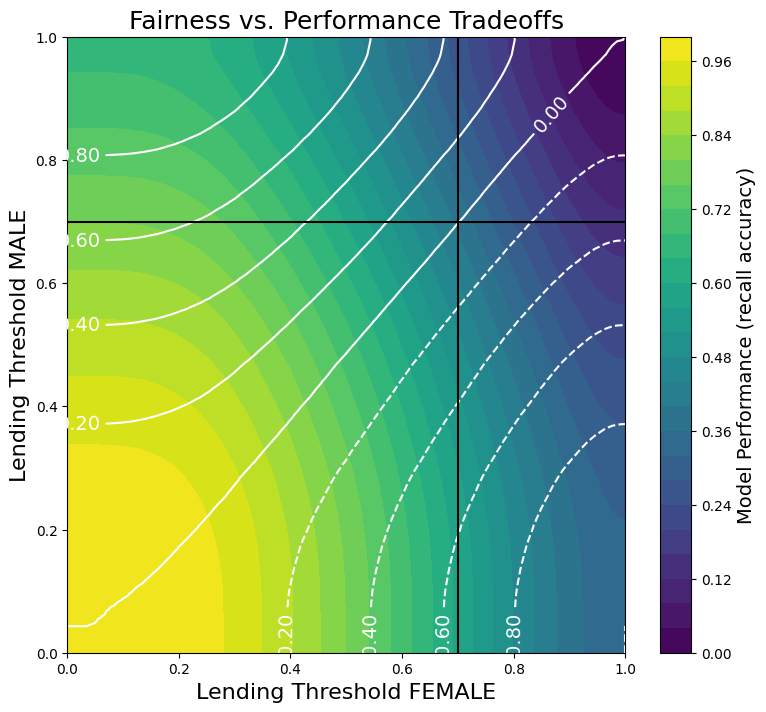

In [ ]:
# Plot
plt.figure(figsize=(9,8))
plt.title('Fairness vs. Performance Tradeoffs', fontsize=18)
plt.xlabel('Lending Threshold FEMALE', fontsize=16)
plt.ylabel('Lending Threshold MALE', fontsize=16)
plt.xlim(np.min(th_a), np.max(th_a))
plt.ylim(np.min(th_b), np.max(th_b))

bal_acc_lns = plt.contourf(th_a, th_b, sample_split_sweep.tpr, levels=25)

eo_lns = plt.contour(th_a, th_b, sample_split_sweep.dem_parity, colors='white', levels=10)
eo_lns.collections[-1].set_label('equal opportunity')

cbar = plt.colorbar(bal_acc_lns)
cbar.set_label('Model Performance (recall accuracy)', fontsize=14)
plt.clabel(eo_lns, inline=1,fmt='%1.2f', fontsize=14)

plt.axhline(0.7, color='k')
plt.axvline(0.7, color='k')
# # Mark maximums
# # plt.plot([0, 1], [0, 1], c='gray', ls=':', label='single threshold')
# plt.scatter(best_th_a, best_th_b, c='b', marker='d', s=100, label= 'max bal acc', zorder=2)
# plt.scatter(best_th, best_th, c='r', marker='x', s=100, label= 'single TH bal acc', zorder=2)
# plt.scatter(best_con_th_a, best_con_th_b, c='purple', marker='*', s=100, label= 'equal opp bal acc', zorder=2)
# lgnd = plt.legend(framealpha=0.3, facecolor='black', fontsize=12, loc='upper right')
# for text in lgnd.get_texts():
#     text.set_color("white")
# plt.show()

In [ ]:
recall_score(y_true=s_df['good30'], y_pred=s_df['above_gcredit'])

0.38906028568920326

In [ ]:
s_df.loc[~s_df.sf_mask_gender & s_df.above_normal==1].sort_values('prediction', ascending=True)

,good30,above_normal,prediction,gender,sf_mask_gender
270074,1,1,0.005055,MALE,False
181343,1,1,0.005130,MALE,False
110603,1,1,0.005861,MALE,False
165273,1,1,0.006419,MALE,False
441980,1,1,0.007722,MALE,False
...,...,...,...,...,...
246259,1,1,0.499961,MALE,False
320529,1,1,0.499967,MALE,False
406807,1,1,0.499968,MALE,False
403325,0,1,0.499981,MALE,False


In [ ]:
recall_score(y_true, y_pred)

0.7016471716249688

In [ ]:
n = P+N

# np.divide((1-N/n)*tpr, PP/n), PP/n
tpr*P, PP, np.divide(tpr*P, PP)

<ipython-input-120-884515188ffb>:4: RuntimeWarning: invalid value encountered in true_divide
  tpr*P, PP, np.divide(tpr*P, PP)


(array([0.00000e+00, 1.00000e+00, 4.80000e+01, ..., 4.13011e+05,
        4.13011e+05, 4.13011e+05]),
 array([0.00000e+00, 1.00000e+00, 4.80000e+01, ..., 4.63153e+05,
        4.63163e+05, 4.63163e+05]),
 array([       nan, 1.        , 1.        , ..., 0.89173772, 0.89171847,
        0.89171847]))

In [ ]:
 base_default_rate = 1 - np.mean(y_true)
accept_rate = (1 - base_default_rate) * tpr + base_default_rate * fpr
prob_tp = (1 - base_default_rate) * tpr
_ppv = np.divide(prob_tp, accept_rate, out=np.zeros_like(prob_tp), where=(accept_rate != 0))

In [ ]:
f_or

array([0.10828153, 0.1082813 , 0.10827031, ..., 0.        , 0.        ,
       0.        ])

In [ ]:
f_or

array([0.10828153, 0.1082813 , 0.10827031, ..., 0.        , 0.        ,
       0.        ])

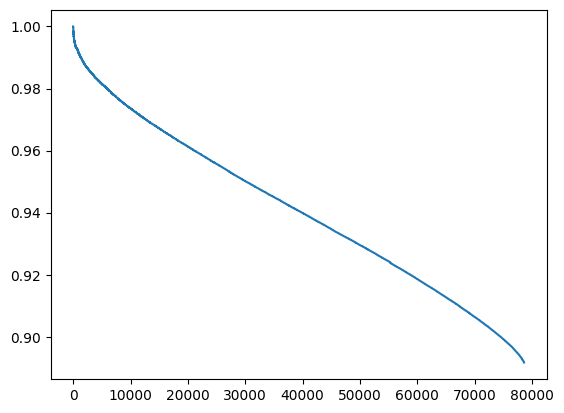

In [ ]:
plt.plot(ppv)

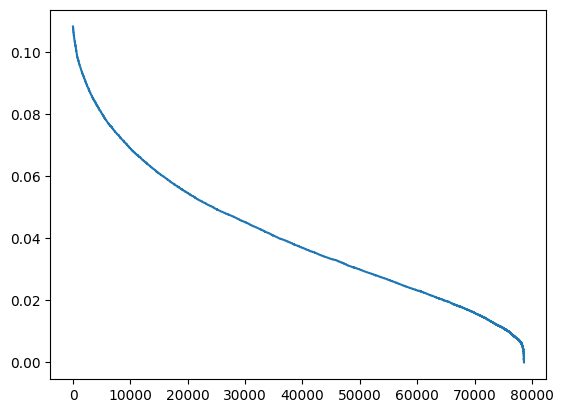

In [ ]:
plt.plot(f_or)

In [ ]:
rates = ModelRates(y_true, y_prob)

In [ ]:
rates.ppv(0.001)

array(0.89171847)

In [ ]:
def compute_rates(y_true, y_prob):


    fpr, tpr, ths = roc_curve(y_true, y_prob)

    ths[0] = 1.0
    ths = np.append(ths, [0])  # Add endpoints for ease of interpolation
    fpr = np.append(fpr, [1])
    tpr = np.append(tpr, [1])

In [ ]:
base_default_rate = 1 - np.mean(y_true)

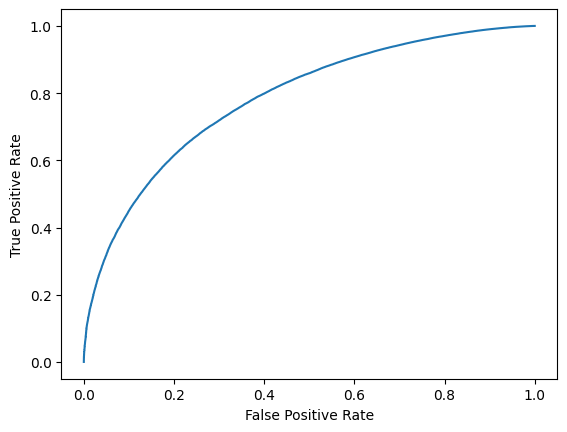

In [ ]:
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()a

In [ ]:
#base_default_rate

np.mean(y_true)

0.10828153371491246

In [ ]:
y_true.value_counts(), 413011/(413011+50152)

(1    413011
 0     50152
 Name: good30, dtype: int64,
 0.8917184662850876)

In [ ]:
fnr = 1 - tpr
tnr = 1 - fpr

P, N = (y_true==1).sum(), (y_true==0).sum()
PP = tpr*P + fpr*N
PN = tnr*P + fnr*N
ppv = pd.Series(np.divide(tpr*P, PP)).bfill().values

f_or = pd.Series(np.divide(fnr*N, PN)).ffill().values
fdr = 1 - ppv
npv = 1 - f_or

<ipython-input-91-792c9c72e960>:7: RuntimeWarning: invalid value encountered in true_divide
  ppv = pd.Series(np.divide(tpr*P, PP)).bfill().values
<ipython-input-91-792c9c72e960>:8: RuntimeWarning: invalid value encountered in true_divide
  f_or = pd.Series(np.divide(fnr*N, PN)).ffill().values


In [ ]:
n = 28394
false_discovery_rate(y_true, (y_prob_good_30 >= ths[n]).map(int)), fdr[n]

(0.048098631579961526, 0.048098631579961526)

In [ ]:
th_a = np.linspace(0.3, 0.7, 500)
th_b = np.linspace(0.3, 0.7, 500)
grid_th_a, grid_th_b = np.meshgrid(th_a, th_b, sparse=True)


In [ ]:
class ModelRates:
    def __init__(self, y_true, y_prob):
        (ths, tpr, fpr, ppv, bdr, ar) = self._compute_rates(y_true, y_prob)
        self.base_default_rate = bdr
        self.tpr = interp1d(ths, tpr)
        self.fpr = interp1d(ths, fpr)
        self.ppv = interp1d(ths, ppv)
        self.accept_rate = interp1d(ths, ar)

    @staticmethod
    def _compute_rates(y_true, y_prob):
        # Vectorizable computation of rates
        fpr, tpr, ths = roc_curve(y_true, y_prob, pos_label=1)
        ths[0] = 1.0  # roc_curve sets max threshold arbitrarily above 1
        ths = np.append(ths, [0.0])  # Add endpoints for ease of interpolation
        fpr = np.append(fpr, [1.0])
        tpr = np.append(tpr, [1.0])
        base_default_rate = 1 - np.mean(y_true)
        accept_rate = (1 - base_default_rate) * tpr + base_default_rate * fpr
        prob_tp = (1 - base_default_rate) * tpr
        ppv = np.divide(prob_tp, accept_rate, out=np.zeros_like(prob_tp), where=(accept_rate != 0))
        return ths, tpr, fpr, ppv, base_default_rate, accept_rate